# Document Processor Service Experience Notebook

## Objectif
Ce notebook va démontrer les fonctionnalités principales du service de traitement de documents bancaires, en couvrant :
1. Conversion PDF en images
2. Détection des tableaux
3. Extraction OCR
4. Extraction des transactions
5. Validation des transactions

In [1]:
# Imports nécessaires
import sys
import os
from pathlib import Path

# Ajout du chemin du projet
sys.path.append(os.path.abspath('../'))

# Imports des composants du service
from core.config import ServiceConfig
from services.tableau.extractor import TableauExtractor
from services.ocr.extractor import OcrExtractor
from services.processor.processor import DocumentProcessor

# Imports additionnels
import doctr.models
import cv2
import matplotlib.pyplot as plt

/Users/yousrimaazaoui/Documents/projets/test-debile/cashflow-analyzer-supabase/services/document-processor/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration du Service

In [2]:
# Initialisation de la configuration
config = ServiceConfig()


# config.ocr.x_tolerance = 50

# for key, value in config.ocr.__dict__.items():
#     print(f"{key} : {value}")

In [21]:
# Initialisation de la configuration
config = ServiceConfig()
config.ocr.y_tolerance = 16
config.ocr.x_tolerance = 50
# Configuration du modèle OCR
device = config.tableau.torch_device
ocr_model = doctr.models.ocr_predictor(pretrained=True).to(device)
ocr_extractor = OcrExtractor(ocr_model=ocr_model, config=config)
# Création des extracteurs
tableau_extractor = TableauExtractor(config)


## Étape 1 : Conversion PDF en Images

Nombre de pages : 1


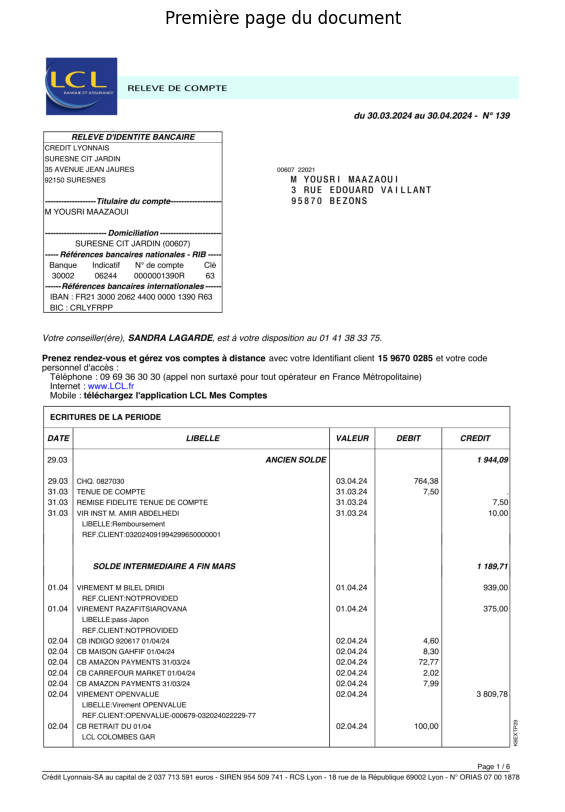

In [14]:
from services.tableau.pdf_processor import PDFProcessor

# Chemin du PDF à traiter
pdf_path = Path('page_1.pdf')


# Conversion du PDF en images
page_images = PDFProcessor.convert_to_images(pdf_path)

# Affichage du nombre de pages
print(f'Nombre de pages : {len(page_images)}')

# Visualisation de la première page
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(page_images[0], cv2.COLOR_BGR2RGB))
plt.title('Première page du document')
plt.axis('off')
plt.show()

## Étape 2 : Détection des Tableaux


0: 640x480 1 borderless, 47.2ms
Speed: 3.8ms preprocess, 47.2ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 480)


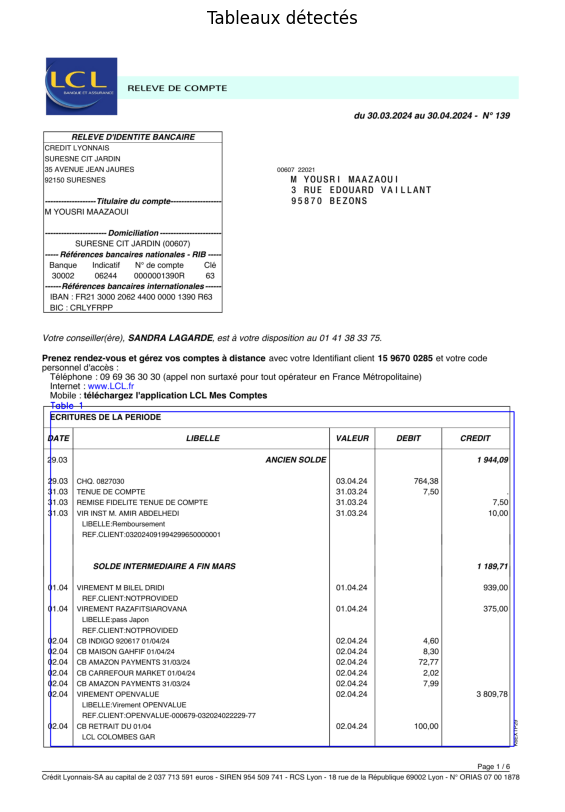

Nombre de tableaux détectés : 1


In [15]:
# Détection des tableaux sur la première page
first_page = page_images[0]
detected_tables = tableau_extractor.process_page(first_page, page_num=0)

# Visualisation des tableaux détectés
detected_image = tableau_extractor.visualize_detections(first_page, 
    [table.coordinates for table in detected_tables])

plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
plt.title('Tableaux détectés')
plt.axis('off')
plt.show()

print(f'Nombre de tableaux détectés : {len(detected_tables)}')

## Étape 3 : Extraction OCR des Tableaux

In [6]:
first_table = detected_tables[0]

first_table.coordinates.to_list()

[126, 1183, 1569, 2226]

In [7]:
first_page.shape

(2400, 1700, 3)

Lignes extraites :
ECRITURES DE LA PERIODE
DATE LIBELLE VALEUR DEBIT CREDIT
9.03 ANCIENSOLDE 1944,09
29.03 CHQ. 0827030 03.04.24 -764.38
31.03 TENUE DE COMPTE 31.03.24 -7.5
31.03 REMISE FIDELITETENUEDECOMPTE 31.03.24 7,50
31.03 VIR INSTM.AMIRABDELHEDI 31.03.24 10,00
LIBELLE:Remboursement
REF.CLIENT:032024091994299650000001
SOLDEINTERMEDIAIREAFINMARS 1 189,71
1.04 VIREMENTMBILELDRIDI 01.04.24 939,00
REF.CLIENTENOTPROVIDED
1.04 VIREMENTRAZAFISAROVANA 01.04.24 375,00
LIBELLE:passJapon
REF.CLIENT:NOTPROVIDED
02.04 CBINDIGO 920617 01/04/24 02.04.24 -4.6
02.04 CBMAISON GAHFIF01/04/24 02.04.24 -8.3
2.04 CBAMAZON PAYMENTS 31/03/24 02.04.24 -72.77
2.04 CBCARREFOUR MARKET01/04/24 02.04.24 -2.02
02.04 CBAMAZON PAYMENTS 31/03/24 02.04.24 -7.99
2.04 VIREMENTOPENVALUE 02.04.24 3 809,78
LIBELLEVrement OPENVALUE
REF.CLIENT:OPENVALUE-000679-032024022229-77
02.04 CBRETRAITDU01/04 02.04.24 -100.0
LCL COLOMBES GAR


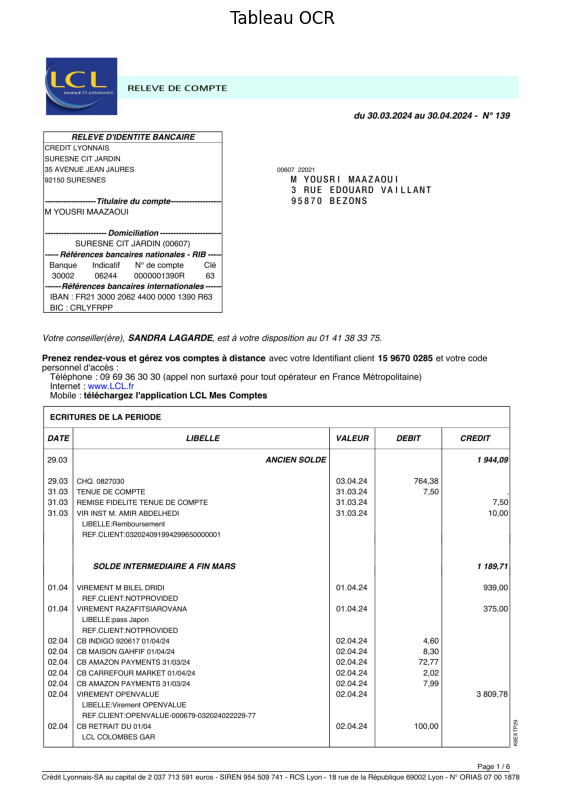

In [36]:
config = ServiceConfig()
config.ocr.y_tolerance = 20
config.ocr.x_tolerance = 3
# Configuration du modèle OCR
device = config.tableau.torch_device
ocr_model = doctr.models.ocr_predictor(pretrained=True).to(device)
ocr_extractor = OcrExtractor(ocr_model=ocr_model, config=config)

# Extraction OCR du premier tableau
first_table = detected_tables[0]
table_image = first_table.image
page_num  = first_table.page_number
# Extraction du texte
extracted_lines = ocr_extractor.extract_text_from_region(
    first_page, 
    first_table.coordinates.to_list(), 
    page_num
    
)

# Affichage des lignes extraites
print("Lignes extraites :")
for line in extracted_lines:
    words_text = ' '.join([word['text'] for word in line['words']])
    print(words_text)

# Visualisation du tableau
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(table_image, cv2.COLOR_BGR2RGB))
plt.title('Tableau OCR')
plt.axis('off')
plt.show()

## Étape 4 : Extraction des Transactions

In [9]:
from services.processor.transaction_extractor import TransactionExtractor

# Créer un extracteur de transactions
transaction_extractor = TransactionExtractor(config)

# Extraction des transactions
transactions = transaction_extractor.extract_transactions(extracted_lines, page_num=0)

# Affichage des transactions
print("Transactions extraites :")
for transaction in transactions:
    print(f"Date: {transaction.date}, "
          f"Description: {transaction.description}, "
          f"Montant: {transaction.amount}")

2024-12-22 05:39:59.420 | INFO     | core.logger:info:96 | Transaction trouvée: Date=09.03.2024, Libellé=ANCIENSOLDE, Montant=1944.09
2024-12-22 05:39:59.421 | INFO     | core.logger:info:96 | Transaction trouvée: Date=29.03.2024, Libellé=CHQ. 0827030 03.04.24, Montant=-764.38
2024-12-22 05:39:59.422 | INFO     | core.logger:info:96 | Transaction trouvée: Date=31.03.2024, Libellé=TENUEDECOMPTE 31.03.24, Montant=-7.5
2024-12-22 05:39:59.423 | INFO     | core.logger:info:96 | Transaction trouvée: Date=31.03.2024, Libellé=REMISEFIDELITETENUEDECOMPTE 31.03.24, Montant=7.50
2024-12-22 05:39:59.424 | INFO     | core.logger:info:96 | Transaction trouvée: Date=31.03.2024, Libellé=VIRINSTM.AMIRABDELHEDI 31.03.24, Montant=10.00
2024-12-22 05:39:59.424 | INFO     | core.logger:info:96 | Transaction trouvée: Date=01.04.2024, Libellé=VIREMENTMBILELDRIDI 01.04.24, Montant=939.00
2024-12-22 05:39:59.425 | INFO     | core.logger:info:96 | Transaction trouvée: Date=01.04.2024, Libellé=VIREMENTRAZAFISAR

## Étape 5 : Validation des Transactions

In [10]:
from services.processor.validator import TransactionValidator

# Créer un validateur de transactions
validator = TransactionValidator(config)

# Validation des transactions
valid_transactions = validator.validate_transactions(transactions)

print("Transactions valides :")
for transaction in valid_transactions:
    print(f"Date: {transaction.date}, "
          f"Description: {transaction.description}, "
          f"Montant: {transaction.amount}")

Transactions valides :
Date: 2024-03-09, Description: ANCIENSOLDE, Montant: 1944.09
Date: 2024-03-29, Description: CHQ. 0827030 03.04.24, Montant: -764.38
Date: 2024-03-31, Description: TENUEDECOMPTE 31.03.24, Montant: -7.5
Date: 2024-03-31, Description: REMISEFIDELITETENUEDECOMPTE 31.03.24, Montant: 7.50
Date: 2024-03-31, Description: VIRINSTM.AMIRABDELHEDI 31.03.24, Montant: 10.00
Date: 2024-04-01, Description: VIREMENTMBILELDRIDI 01.04.24, Montant: 939.00
Date: 2024-04-01, Description: VIREMENTRAZAFISAROVANA 01.04.24, Montant: 375.00
Date: 2024-04-02, Description: CBINDIGO 920617 01/04/24 02.04.24, Montant: -4.6
Date: 2024-04-02, Description: CBMAISONGAHFIF01/04/24 02.04.24, Montant: -8.3
Date: 2024-04-02, Description: CBAMAZONPAYMENTS31/03/24 02.04.24, Montant: -72.77
Date: 2024-04-02, Description: CBCARREFOURMARKET01/04/24 02.04.24, Montant: -2.02
Date: 2024-04-02, Description: CBAMAZONPAYMENTS31/03/24 02.04.24, Montant: -7.99
Date: 2024-04-02, Description: VIREMENTOPENVALUE 02.04

## Traitement Complet du Document

In [11]:
# Créer un processeur de documents
document_processor = DocumentProcessor(
    tableau_extractor=tableau_extractor,
    ocr_extractor=ocr_extractor,
    config=config
)

# Traitement complet du document
processed_document = document_processor.process_document(pdf_path)

# Résumé du traitement
print(f"Nombre total de transactions : {len(processed_document.transactions)}")
print(f"Temps de traitement : {processed_document.processing_time:.2f} secondes")

# Affichage détaillé des transactions
for transaction in processed_document.transactions:
    print(f"Date: {transaction.date}, "
          f"Description: {transaction.description}, "
          f"Montant: {transaction.amount}, "
          f"Texte brut: {transaction.raw_text}")

2024-12-22 05:39:59.476 | INFO     | core.logger:log_process_start:79 | 
🚀 🚀 🚀 
Starting processing of: page_1.pdf
🚀 🚀 🚀 
2024-12-22 05:39:59.476 | INFO     | core.logger:info:96 | ➡️ Starting table extraction from: page_1.pdf
2024-12-22 05:39:59.600 | INFO     | core.logger:info:96 | 📄 Converted PDF to 1 images

0: 640x480 1 borderless, 39.7ms
Speed: 2.8ms preprocess, 39.7ms inference, 12.2ms postprocess per image at shape (1, 3, 640, 480)
2024-12-22 05:39:59.658 | INFO     | core.logger:info:96 | 📊 Found 1 tables in total
2024-12-22 05:39:59.660 | INFO     | core.logger:info:96 | 🖼️  Saving page image to: output/pages/page_0.png
2024-12-22 05:39:59.660 | INFO     | core.logger:info:96 | 🖼️  Saving visualized detections to: output/tables/page_0_tables.png
2024-12-22 05:40:00.097 | INFO     | core.logger:info:96 | Transaction trouvée: Date=09.03.2024, Libellé=ANCIENSOLDE, Montant=1944.09
2024-12-22 05:40:00.098 | INFO     | core.logger:info:96 | Transaction trouvée: Date=29.03.2024, Li

## Visualisation Finale

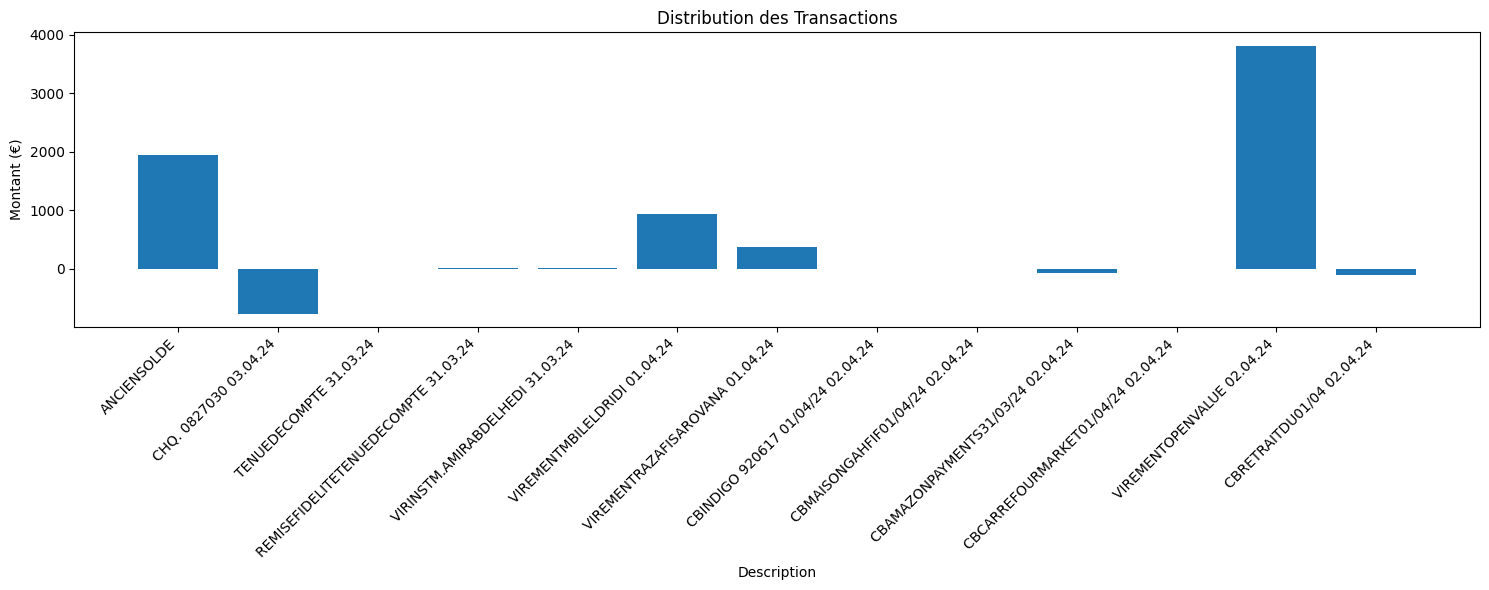

Résumé des transactions :
            amount
count    14.000000
mean    436.986429
std    1151.680991
min    -764.380000
25%      -8.222500
50%      -3.310000
75%     283.750000
max    3809.780000


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir les transactions en DataFrame
transactions_df = pd.DataFrame([
    {
        'date': t.date, 
        'amount': float(t.amount), 
        'description': t.description
    } for t in processed_document.transactions
])

# Graphique des transactions
plt.figure(figsize=(15, 6))
plt.title('Distribution des Transactions')
plt.bar(transactions_df['description'], transactions_df['amount'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Description')
plt.ylabel('Montant (€)')
plt.tight_layout()
plt.show()

# Résumé des transactions
print("Résumé des transactions :")
print(transactions_df.describe())